# Implementing Global Sensitivity Analysis for Different Cases of the Macrophage Tumor Population Model
## Tumor Volume is the Outcome of Interest for 3 Cases

### Cases represent a parameter set with low tumor volume (Case 1), a parameter set which produces bistability (Case 2), and a parameter set which yields a high tumor volume (Case 7)
Note: the transition from Case 1 to Case 2 to Case 7 come from increasing $\alpha_{1m}$, and corresponds to simulations in our manuscript.

### Define System of ODEs

Note: this update adds parameter $K$.

Our state variables are $T$, tumor volume, $M_0$, naive macrophages, $M_1$,  M1-like macrophages, $M_2$, M2-like macrophages, and $M_m$, mixed (or $M_1/M_2$) phenotype macrophages.


Model Equations (see Overleaf document for pathways and justification):

$\frac{dT}{dt}={p_T \cdot T \cdot \left(1-T\right)(h -r_1M_1+ r_2M_2 )} - {d_T T}$
$\frac{dM_0}{dt}={p_{0}T\left(1-\frac{M_0+M_1+M_2+M_m}{K}\right)\left(1+\gamma M_1\right)} - \left({d_{0}} + {\alpha_{01}} + {\alpha_{02} \left(1+\frac{\beta T}{T+f}\right)}\right)M_0 + {\alpha_{10}M_1} + {\alpha_{20}M_2}$
$ \frac{dM_1}{dt}= -\left({d_{1}} + {\alpha_{10}}  + {\alpha_{12} \left(1+ \frac{\beta T}{T+f}\right)} + {\alpha_{1m}  \left(1+ \frac{\beta T}{T+f}\right)}\right)M_1 + {\alpha_{01}M_0} +{\alpha_{21}M_2}  + {\alpha_{m1}M_m}$
$\frac{dM_2}{dt}= -\left({d_{2}} +{\alpha_{20}} + {\alpha_{21}} + {\alpha_{2m}} \right)M_2+ \left({\alpha_{02}M_0 } + {\alpha_{12}M_1 } + {\alpha_{m2}M_m  }\right)\cdot \left(1+ \frac{\beta T}{T+f}\right)$
$\frac{dM_m}{dt}= -\left({d_{m}} + {\alpha_{m1}} + {\alpha_{m2} \left(1+ \frac{\beta T}{T+f}\right)}\right)M_m + {\alpha_{1m}\left(1+\frac{\beta T}{T+ f}\right)M_1}+ {\alpha_{2m}M_2 }$

Note, this system has 24 parameters which will be explored.

4 parameters set to zero at baseline, reflecting the impossibility of transitions between certain states (e.g., alpha12 equaling zero mean an M1 macrophage can't switch directly to an M2 macrophage (it has to pass through the mixed phenotype first)).




Install libraries.  Note: If working on a computer without SALib installed, type conda install SALib in terminal before importing modules.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol

0.008530139923095703


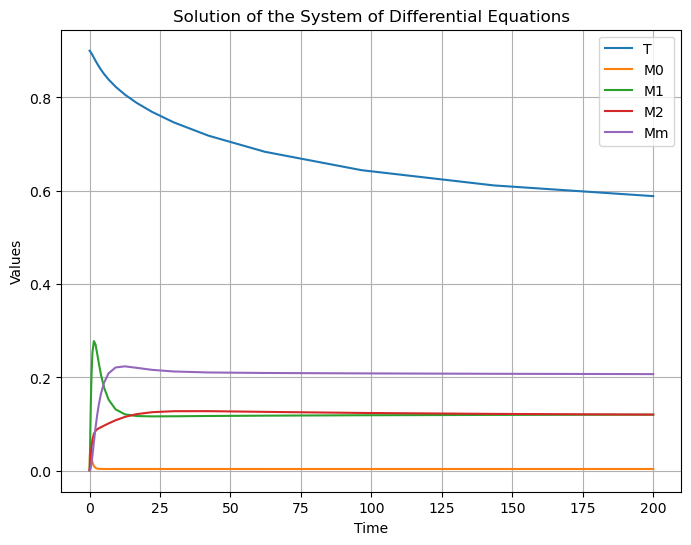

In [2]:
# Define the system of differential equations
# this modification replaces f with K in the first term of the second equation.

def equations(t, y, pT, h, f, dT, r1, r2, p0, g, d0, alpha01, alpha02, alpha10, alpha20, b, d1, alpha1m, d2, 
              alpham2, dm, alpham1,alpha2m, alpha12, alpha21, K):
    T, M0, M1, M2, Mm = y

    f0 = pT * T * (1 - T) * (h - r1 * M1 + r2 * M2) - dT * T
    f1 = (p0 * T * (1 - (M0 + M1 + M2 + Mm) / K) * (1 + g * M1) +
          alpha10 * M1 + alpha20 * M2 -
          d0 * M0 - alpha01 * M0 -
          alpha02 * M0 * (1 + b * T / (T + f)))
    f2 = (-d1 * M1 - alpha10 * M1 +
          alpha01 * M0 + alpha21 * M2 + alpham1 * Mm -
          (alpha12 * M1 + alpha1m * M1) * (1 + b * T / (T + f)))
    f3 = (-d2 * M2 - alpha20 * M2 - alpha21 * M2 - alpha2m * M2 +
          (alpha02 * M0 + alpha12 * M1 + alpham2 * Mm) * (1 + b * T / (T + f)))
    f4 = (-dm * Mm - alpham1 * Mm + alpha2m * M2 +
          (alpha1m * M1 - alpham2 * Mm) * (1 + b * T / (T + f)))

    return [f0, f1, f2, f3, f4]

# Define the time span
t_span = (0, 200)  # Define the start and end time

# Define initial conditions [T0, M0_0, M1_0, M2_0, Mm_0]
T0 = .9  # initial tumor burden (scaled volume)
M00 = .0003  # initial M0
M10 = .001  # initial M1
M20 = .001  # initial M2
Mm0 = 0  # initial Mm
initial_conditions = [T0, M00, M10, M20, Mm0]


#  baseline parameter value 
pT_val = .23
h_val = .1
f_val = .5
dT_val = .01
r1_val = 1
r2_val = 1
p0_val = .7
g_val = 1
d0_val = .1
# alpha01 = 1 replace with bistable value
# alpha02 = .1 replace with bistable value
alpha10_val = .0001
alpha20_val = .0001
b_val = 2
d1_val = .1
# alpha1m = .001 replace with bistable value
d2_val = .1
# alpham2 = .01 replace with bistable value
dm_val = .1

# Case 3 original bistable (medium/low) -- commented out originals above
alpham2_val = .01
alpha02_val = 1
alpha1m_val = .1
alpha01_val = 10

# originally assume these are zero
alpham1_val = 0
alpha2m_val = 0
alpha12_val = 0
alpha21_val = 0

K_val = .5 # added this parameter


# Define parameters
params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val, K_val)

start = time.time() # time process

# Solve the system of differential equations with parameters
sol = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

end = time.time()
print(end-start)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Differential Equations')
plt.legend(['T', 'M0', 'M1', 'M2', 'Mm'])
plt.grid(True)
plt.show()

# Implement GSA

## Case 1 (Low)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/2917395775.py:62: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


4713.729719877243


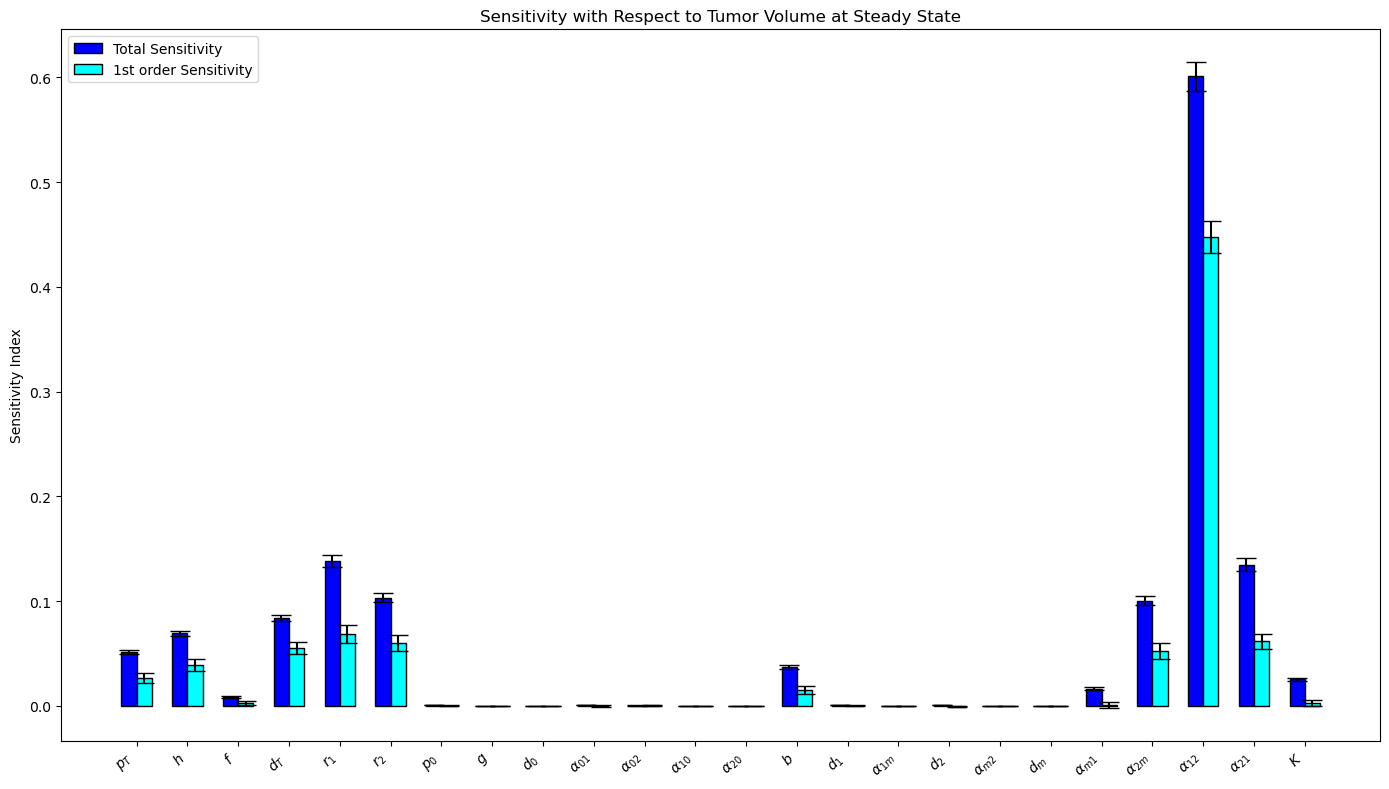

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
import time

# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1
alpha02 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
alpha1m = .001
d2 = .1
alpham2 = .01
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case1-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 2 (Bistability)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/900620921.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


3537.221876859665


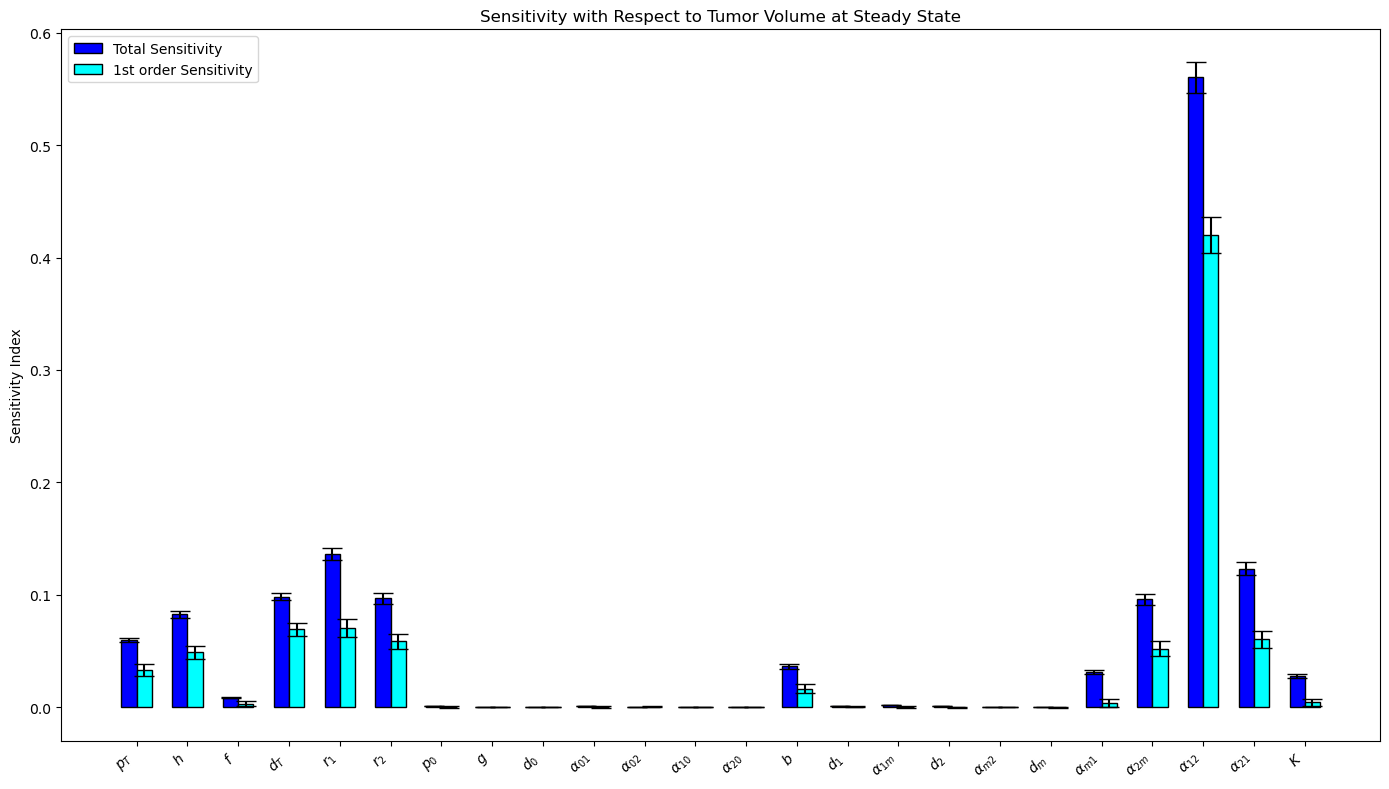

In [4]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1
alpha02 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
alpha1m = .1 # changed from case 1
d2 = .1
alpham2 = .01
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case2-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 7 (High Tumor Volume)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/508997953.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


3457.4937529563904


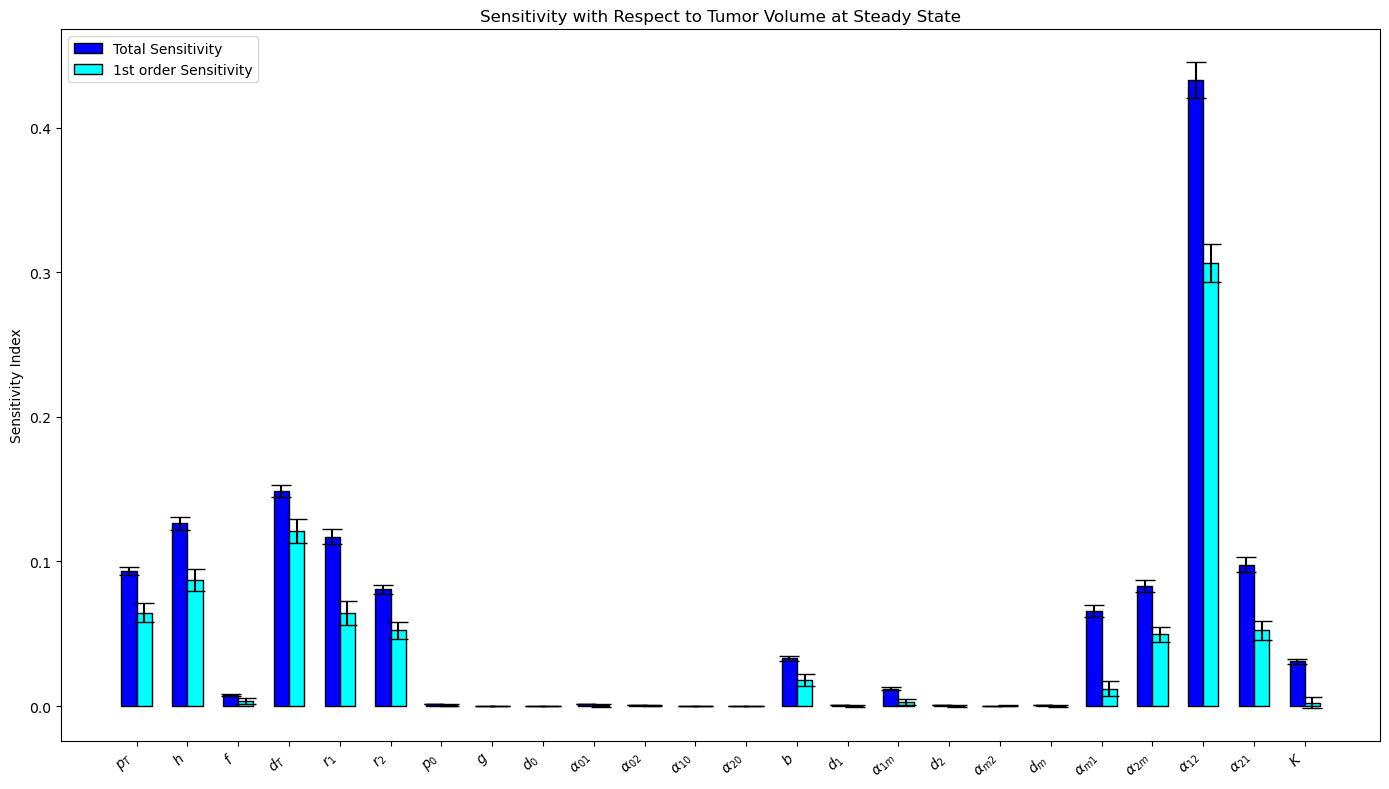

In [5]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1
alpha02 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
alpha1m = .5 # changed from case 1 and case 2
d2 = .1
alpham2 = .01
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case7-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 3 (Bistable)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/2942542623.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


3899.3488681316376


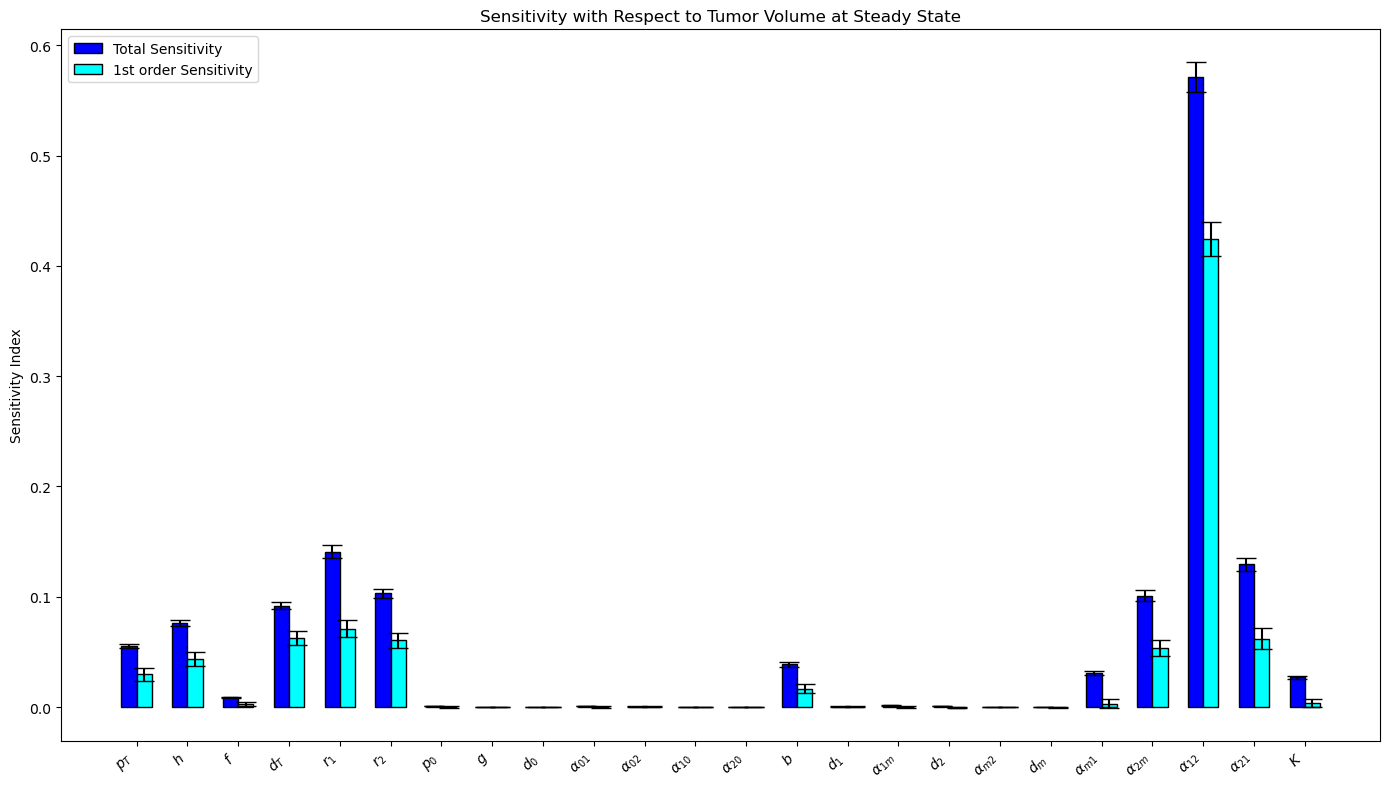

In [6]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 10 # changed
alpha02 = 1 # changed
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
alpha1m = .1 # changed 
d2 = .1
alpham2 = .01
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case3-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 4

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/3578676510.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


5712.049663066864


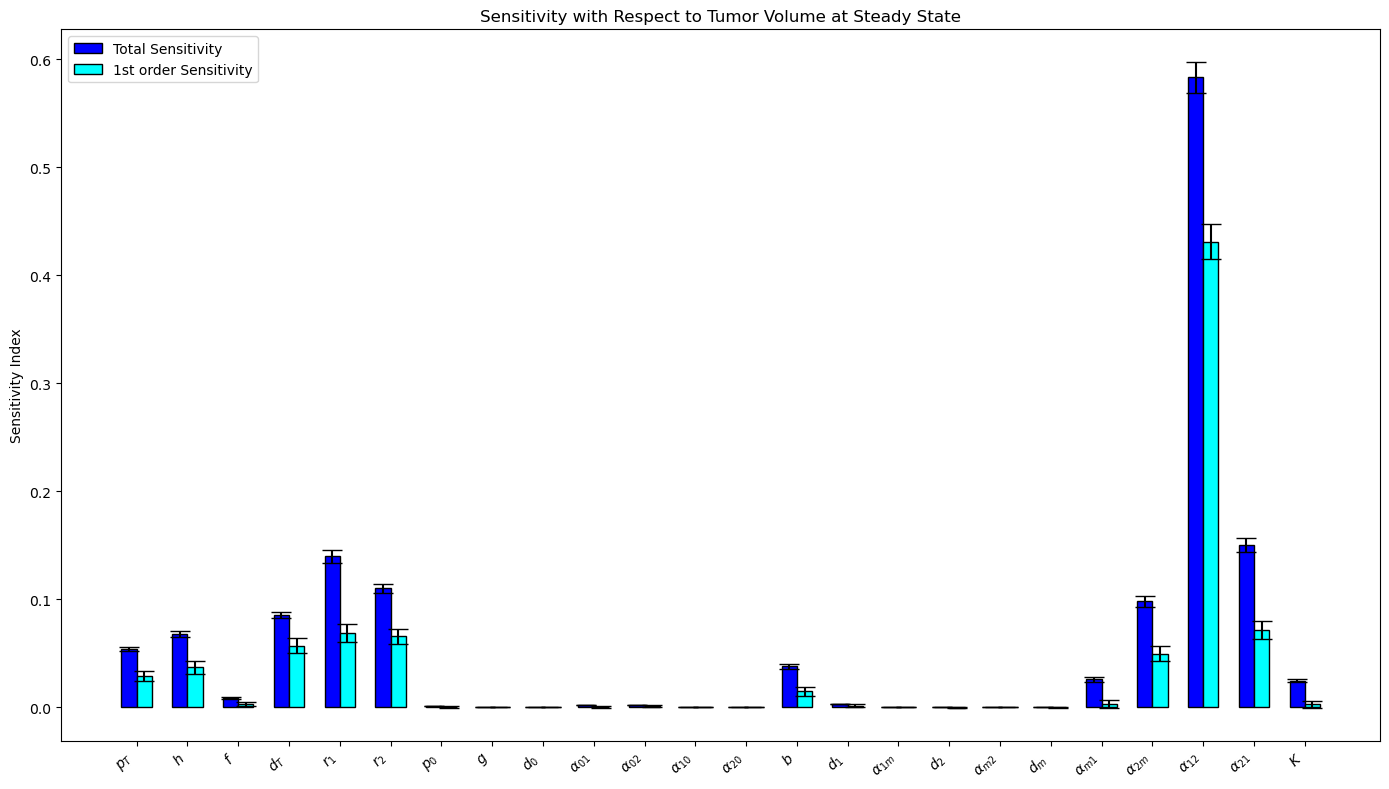

In [7]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1 # checked
alpha02 = 1 # changed
alpha10 = .0001
alpha20 = .1 # changed
b = 2
d1 = .1
alpha1m = .001 # changed 
d2 = .1
alpham2 = .01 # changed
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case4-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 5 (bistable)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/1436022646.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


5352.29739689827


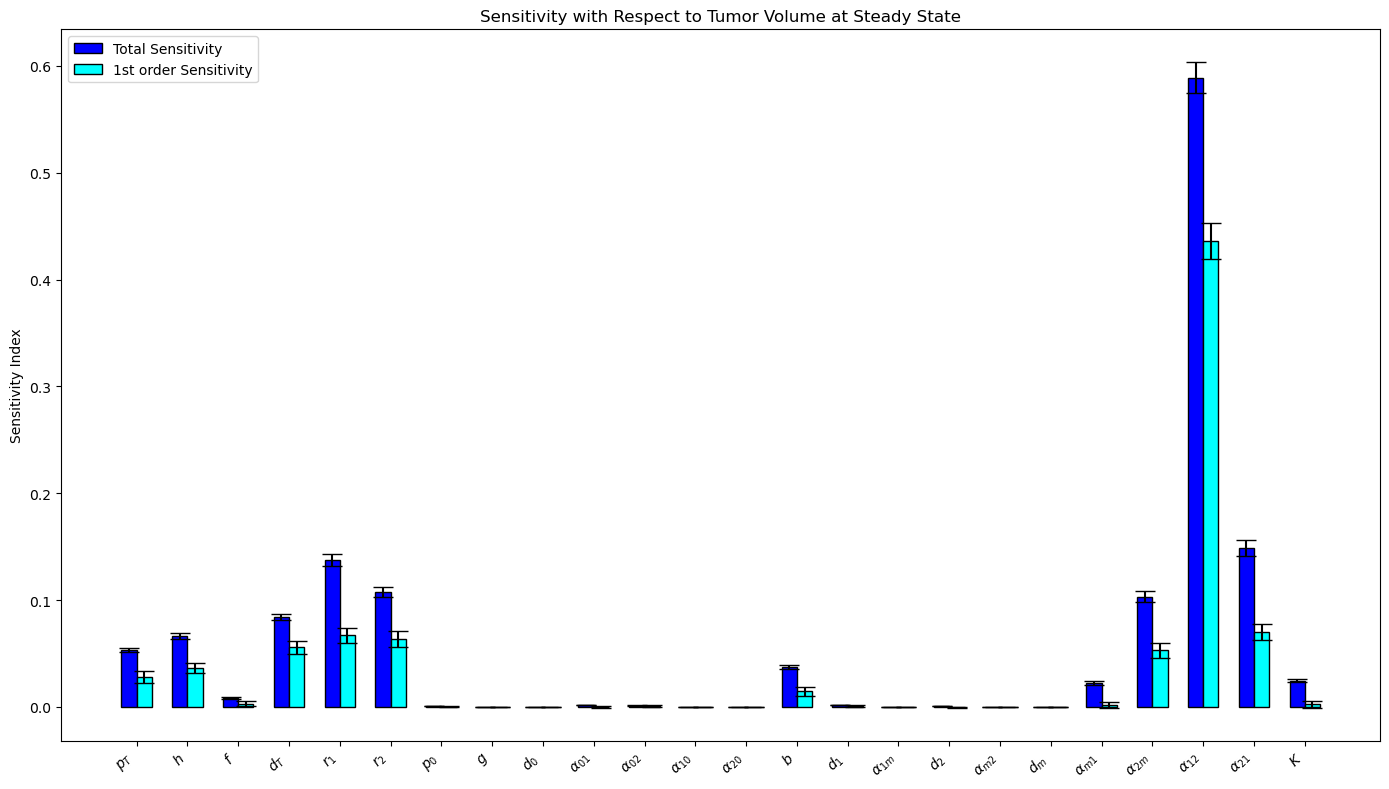

In [8]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1 # checked
alpha02 = .5 # changed
alpha10 = .0001
alpha20 = .0001 # changed
b = 2
d1 = .1
alpha1m = .001 # changed 
d2 = .1
alpham2 = .01 # changed
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case5-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 6 (high)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_27700/3955302633.py:55: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


34333.8767619133


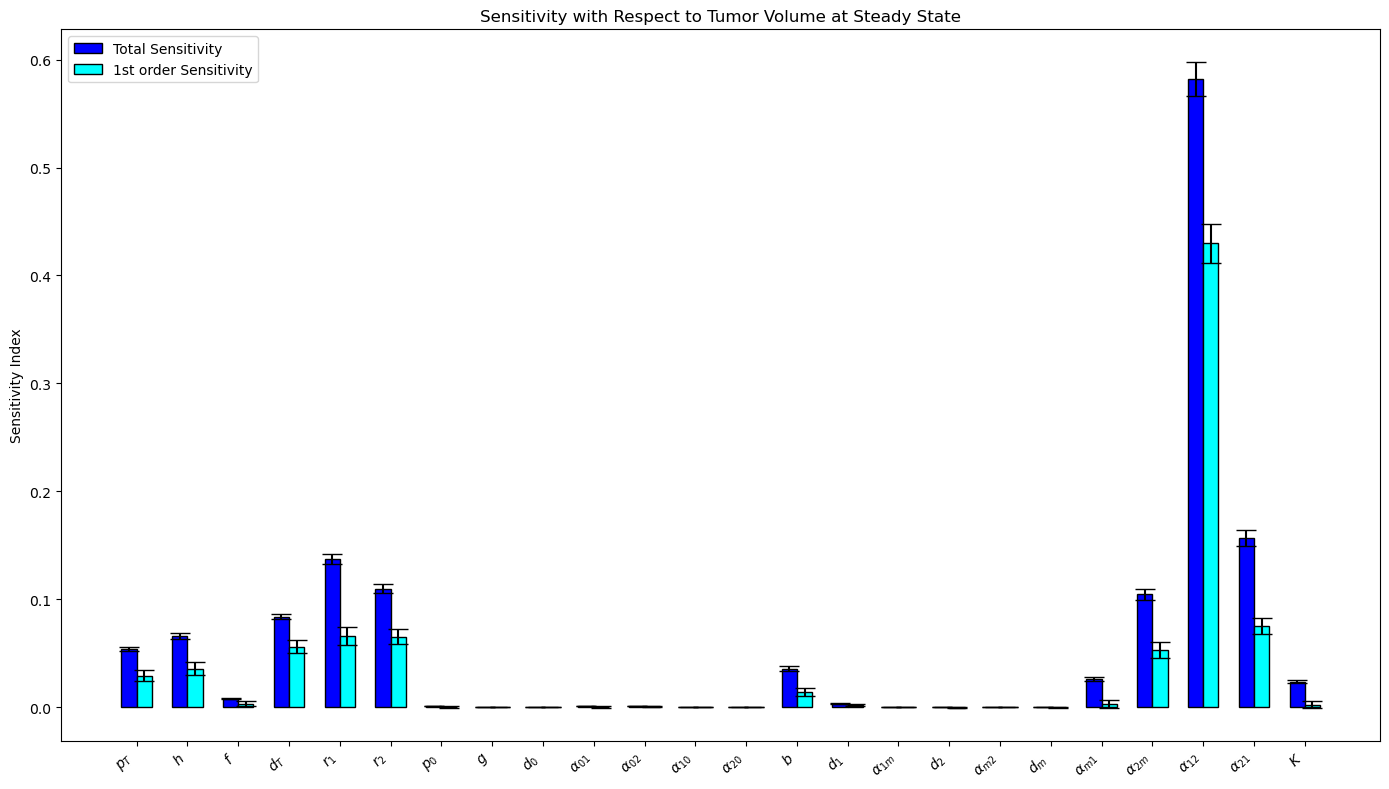

In [9]:
# Define baseline parameter values 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha01 = 1 # checked
alpha02 = 1 # changed
alpha10 = .0001
alpha20 = .0001 # changed
b = 2
d1 = .1
alpha1m = .001 # changed 
d2 = .1
alpham2 = .01 # changed
dm = .1
K = .5  

# Define parameter problem and bounds
problem = {
    'num_vars': 24,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],  
               [0.5*h, 1.5*h],  
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0, 1], # alpham1
               [0, 1], # alpha2m
               [0, 1], # alpha12
               [0, 1], # alpha21
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8)) # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels
plt.xticks([r + barWidth/2 for r in range(len(ST_values))], 
           [r'$p_T$', r'$h$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$g$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$b$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], rotation=45, ha='right', fontsize=10)
plt.ylabel(r'Sensitivity Index')
plt.legend()
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State')

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.2)

# Save and show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
f.savefig("GSA-Case6-TumorVolume.pdf", bbox_inches='tight', dpi=300)
plt.show()
